Import Libraries

In [35]:
# 📌 Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string, re, nltk
import joblib

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Download required resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yuvra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuvra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load and Inspect Dataset

In [36]:
# 📁 Step 2: Load Dataset
df = pd.read_csv("Dataset.tsv", sep="\t")
df.dropna(subset=['verified_reviews', 'rating'], inplace=True)

# Filter out neutral ratings (3)
df = df[df['rating'] != 3]
df['Sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
df = df[['verified_reviews', 'Sentiment']]
df.rename(columns={'verified_reviews': 'Review'}, inplace=True)


Data Visualization

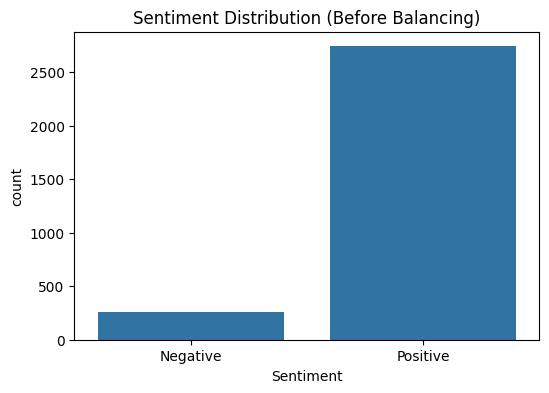

In [37]:
# 📊 Step 3: Visualize Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Distribution (Before Balancing)")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


Balance the Dataset

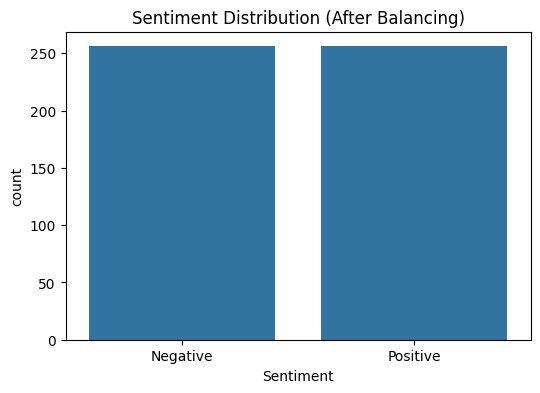

In [38]:
positive = df[df['Sentiment'] == 1]
negative = df[df['Sentiment'] == 0]

positive_downsampled = resample(positive, replace=False, n_samples=len(negative), random_state=42)
df_balanced = pd.concat([positive_downsampled, negative])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Distribution after balancing
plt.figure(figsize=(6,4))
sns.countplot(data=df_balanced, x='Sentiment')
plt.title("Sentiment Distribution (After Balancing)")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


Clean the Reviews

In [39]:
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)

df_balanced['Cleaned_Review'] = df_balanced['Review'].astype(str).apply(clean_text)
df_balanced.head()


,Review,Sentiment,Cleaned_Review
0,It doesn’t always work,0,’ alway work
1,"For the price, the product is nice quality and...",0,price product nice qualiti nice featur definit...
2,I will never buy anything Amazon makes again!T...,0,never buy anyth amazon make againthi fire stic...
3,I’m not sure why or how Amazonia asking me abo...,1,’ sure amazonia ask purchas got gift kid mothe...
4,This device does not interact with my home fil...,0,devic interact home fill appl devic disappoint


Vectorize Text and Split

In [40]:
# 🧠 Step 6: Vectorize Text and Split
X = df_balanced['Cleaned_Review']
y = df_balanced['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000, min_df=5)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


Train Multiple Models and Compare

In [41]:
# 🤖 Step 7: Train Multiple Models and Compare
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    results[name] = {
        "accuracy": acc,
        "roc_auc": auc,
        "model": model
    }

# Convert results to DataFrame
results_df = pd.DataFrame({
    name: {"Accuracy": r["accuracy"], "ROC AUC": r["roc_auc"]}
    for name, r in results.items()
}).T.reset_index().rename(columns={"index": "Model"})

# Display results
print(results_df.sort_values("Accuracy", ascending=False))


                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.825243  0.824432
1          Naive Bayes  0.815534  0.812689
3        Random Forest  0.805825  0.808902
2           Linear SVM  0.786408  0.785417


Visualization of Model Comparison

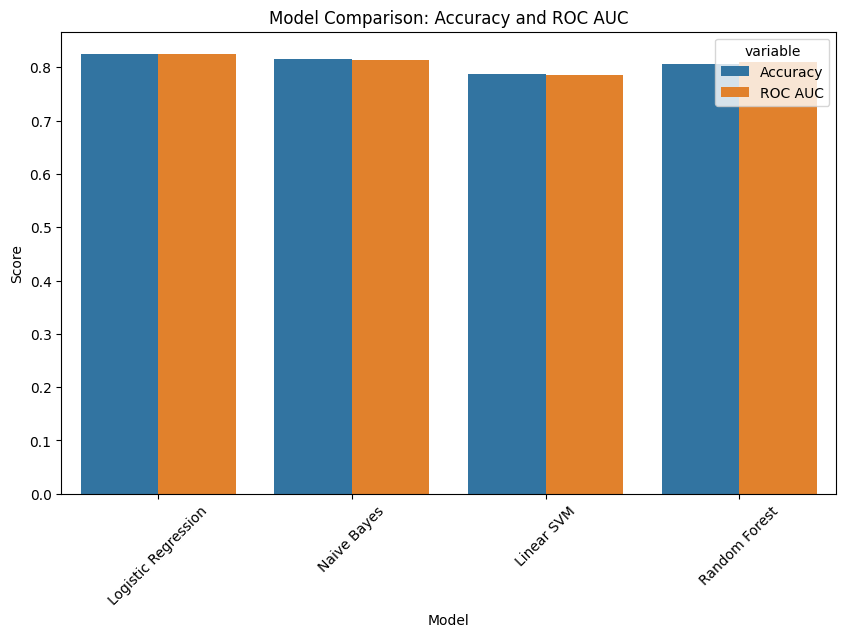

In [42]:
# 📊 Step 8: Visualization of Model Comparison
plt.figure(figsize=(10,6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison: Accuracy and ROC AUC")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

Save Best Model and Vectorizer

In [48]:
# 💾 Step 9: Save Best Model and Vectorizer
best_model_name = results_df.sort_values("Accuracy", ascending=False).iloc[0]["Model"]
best_model = results[best_model_name]["model"]

joblib.dump(best_model, "best_sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print(f"Best Model: {best_model_name} saved.")


Best Model: Logistic Regression saved.


Sample Predictions

In [49]:
# 🧪 Step 9: Sample Predictions
sample_reviews = [
    "This product is amazing! Totally loved it.",
    "Waste of money, very disappointed.",
    "Quality is decent for the price.",
    "I will never buy this again.",
    "good purchase, works as expected.",
    "Not worth the hype, but okay.",
]

sample_cleaned = [clean_text(text) for text in sample_reviews]
sample_vectorized = tfidf.transform(sample_cleaned)
sample_preds = model.predict(sample_vectorized)

for review, pred in zip(sample_reviews, sample_preds):
    print(f"Review: {review}")
    print("Predicted Sentiment:", "Positive" if pred == 1 else "Negative")
    print("-" * 60)


Review: This product is amazing! Totally loved it.
Predicted Sentiment: Positive
------------------------------------------------------------
Review: Waste of money, very disappointed.
Predicted Sentiment: Negative
------------------------------------------------------------
Review: Quality is decent for the price.
Predicted Sentiment: Negative
------------------------------------------------------------
Review: I will never buy this again.
Predicted Sentiment: Negative
------------------------------------------------------------
Review: good purchase, works as expected.
Predicted Sentiment: Positive
------------------------------------------------------------
Review: Not worth the hype, but okay.
Predicted Sentiment: Negative
------------------------------------------------------------
